In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import methods
import pymaster as nmt
from importlib import reload
from tqdm import tqdm

In [2]:
nside = 512
npix = 12*nside**2
lmax = 3*nside-1
n_sims = 10

In [3]:
reload(methods)
# ell_input, TT, TE, EE, BB, PP = np.loadtxt('cl.txt', unpack=True)
ell_input, TT, EE, BB, TE = np.loadtxt('totcls_lensed_r0p1.txt', unpack=True)

# input_cls = np.array([TT, np.zeros_like(BB), BB, TE]) #no EE
input_cls = np.array([TT, EE, BB, TE])
input_cls /= ell_input*(ell_input+1)/2/np.pi 
for c in input_cls: c[0] = 0 
input_cls = input_cls[:,:lmax+1]
input_cls_noBB = np.copy(input_cls)
input_cls_noBB[2] = np.zeros(lmax+1)
ell_input = ell_input[:lmax+1]
c2d = ell_input*(ell_input+1)/2/np.pi

Nl_T = methods.get_Nl(30, 50, -1.8, lmax)
Nl_P = methods.get_Nl(60, 20, -1.4, lmax) 

noise_cls = np.array([Nl_T, Nl_P, Nl_P, np.zeros(lmax+1)])

/tmp/ipykernel_4514/1115978788.py:7: RuntimeWarning: invalid value encountered in true_divide
  input_cls /= ell_input*(ell_input+1)/2/np.pi
/scratch/yuyang/destripe/methods.py:70: RuntimeWarning: divide by zero encountered in power
  model = n * (l/knee)**alpha + n


7.317829132080078


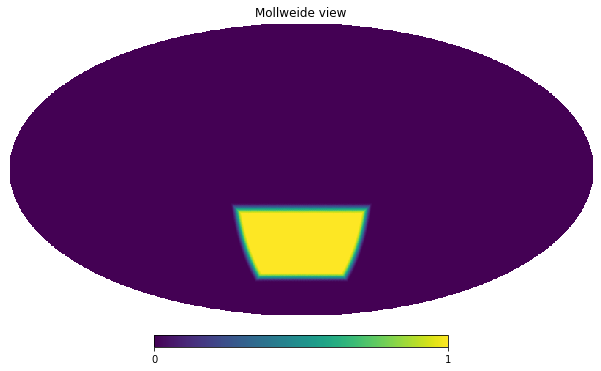

In [4]:
reload(methods)
mask = methods.get_mask(nside)
pix = np.where(mask!=0)[0]
mask_apo = nmt.mask_apodization(mask, 6, apotype='C2')
hp.mollview(mask_apo)
fsky = len(mask_apo[(mask_apo!=0)])/npix
print(fsky*100)

In [5]:
reload(methods)
sigmab = hp.nside2resol(nside)
fwhm = methods.sigma2fwhm(sigmab)
bl = methods.get_bl(nside)
mll = methods.get_mll(mask_apo, nside, pol=True, purify_b=False)
b = nmt.NmtBin.from_nside_linear(nside, 32)
ells = b.get_effective_ells()
c2db = ells * (ells+1) /2/np.pi
masked_cl_noise = (mll@np.concatenate(np.array([Nl_P, np.zeros(lmax+1), np.zeros(lmax+1), Nl_P]))).reshape(4, lmax+1)

In [6]:
n_sims = 16
cl = np.empty((n_sims, 4, len(ells)))
cl_noiseless = np.empty((n_sims, 4, len(ells)))

for i in tqdm(range(n_sims)): 
    input_map = hp.synfast(input_cls, nside, fwhm=fwhm, new=True)
    noise_map = hp.synfast(noise_cls, nside, new=True)
    full_map = input_map + noise_map
    f = nmt.NmtField(mask_apo, mask*[full_map[1], full_map[2]], beam=bl, purify_b=True)
    cl[i] = nmt.compute_full_master(f, f, b, cl_noise=masked_cl_noise)
    
    f = nmt.NmtField(mask_apo, mask*[input_map[1], input_map[2]], beam=bl, purify_b=True)
    cl_noiseless[i] = nmt.compute_full_master(f, f, b)
    
mean = c2db*np.mean(cl, axis=0)
std = c2db*np.std(cl, axis=0)

mean_noiseless = c2db*np.mean(cl_noiseless, axis=0)
std_noiseless = c2db*np.std(cl_noiseless, axis=0)

100%|███████████████████████████████████████████████████| 16/16 [06:34<00:00, 24.63s/it]


[]

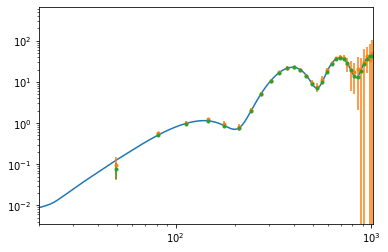

In [7]:
plt.plot(EE)
plt.errorbar(ells, mean[0], std[0], fmt='.')
plt.errorbar(ells, mean_noiseless[0], std_noiseless[0], fmt='.')

plt.xlim(20, 2*nside)
plt.loglog()

(20, 1024)

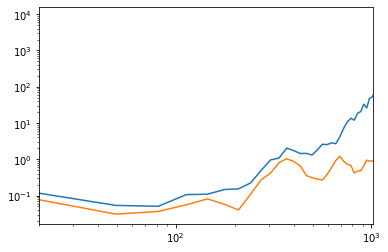

In [18]:
plt.plot(ells, std[0])
plt.plot(ells, std_noiseless[0])
plt.loglog()
plt.xlim(20, 2*nside)

[]

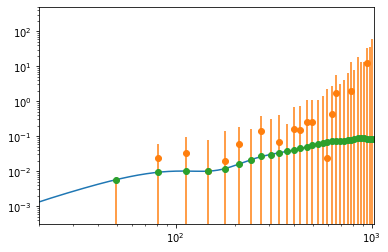

In [11]:
plt.plot(BB)
plt.errorbar(ells, mean[3], std[3], fmt='o')
plt.errorbar(ells, mean_noiseless[3], std_noiseless[3], fmt='o')
plt.xlim(20, 2*nside)
plt.loglog()

[]

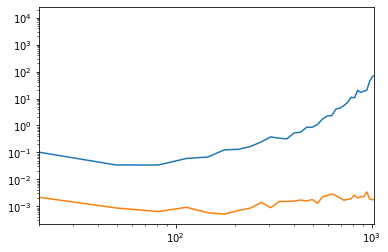

In [17]:
plt.plot(ells, std[3])
plt.plot(ells, std_noiseless[3])
plt.xlim(20, 2*nside)
plt.loglog()